# Pulse Shaping 

The goal of this notebook is to mess around with some common pulse shaping techniques. I want to simulate and compare the following pulse-shaping/windowing options.

1. Rectangular 
2. Gaussian 
3. Sinc 
4. Raised Cosine

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from my_dsp import my_fft, db20 

## Step 1: Generate Data Symbols

The input into a pulse shaping filter is often a set of data symbols. The symbols are simply a set of numbers where each number represents one symbol. It is very common to use complex symbols to simulate IQ based communications systems. A set of symbols can be mathametically describes as:

$$
s_i = \{s_1, s_2, ..., s_{K-1}\}
$$

where each $s_i$ is a complex number denotes as $s_i = s_{Ii} + js_{Qi}$. The set of all $K$ symbols is reffered to as the symbol alphabet. 

If you are tranmitting complex IQ symbols then for a set of $K$ symbols, each symbol ${s_i}$ carries $2*log_2\left({K}\right)$. 

In the case of nulling the Q/imaginary component of the symbols (see BPSK for example) each symbol tranmits $log_2\left({k}\right)$ bits, or half as much as if both components are utalized. 

The code below is an easy way to generate random symbols from an arbitrary alphabet. It utalized the `np.random.choice()` function. 

AttributeError: module 'matplotlib.pyplot' has no attribute 'ylable'

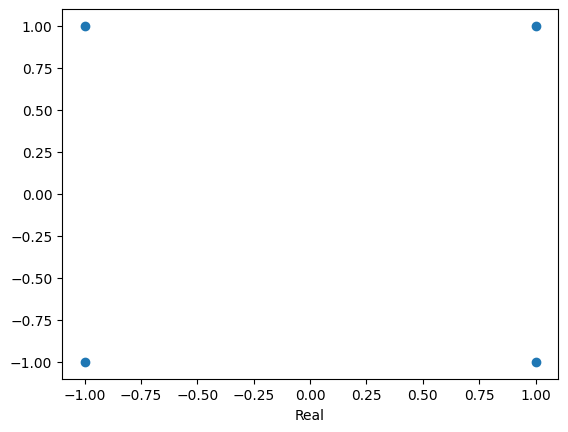

In [40]:
n_symbols = 1

bpsk_alphabet = np.array([1, -1])
qpsk_alphabet = np.array([1+1j, 1-1j, -1+1j, -1-1j])
symbol_alphabet = qpsk_alphabet

data_symbols = np.random.choice(symbol_alphabet, n_symbols)

T_sym = 1 #seconds
span = 1 #number of symbol periods the pulse spans
sps = 200 #number of samples per symbol
fs = sps/T_sym #sample rate of pulse-shaped signal
t = (1/fs)*np.arange(0, int(n_symbols*sps)) #time vector

plt.scatter(np.real(symbol_alphabet), np.imag(symbol_alphabet))
plt.xlabel('Real')
plt.ylable('Imag')
plt.title('Possible Data Symbols')

# Step 2: Generate A Pulse Waveform

In [50]:
def pulse_shape(data_symbols:np.array, pulse_signal:np.array, flatten=False)->np.array:
    """ Generate pulse shaped data array.
       
        Positional Arguments:
            data_symbols: set of data symbols to be shaped.
            pulse_signal: The pulse waveform that does the shaping.
            flatten: T/F, if true then the returned data will be a row vector with shape (1, n_sym*sps).
                          if false then the returned data will be a matrix where each row is a pulse-shaped symbol. dim -> (n_sym, sps)
            
    """
    n_sym = len(data_symbols)
    sps = len(pulse_signal)
    data = np.multiply(data_symbols.reshape(n_sym, 1), pulse_signal.reshape(1, sps))
    if flatten:
        return data.reshape(1, int(n_sym*sps))
    else:
        return data 

def create_plot(t, data):
    f, data_f = my_fft(data.reshape(data.size), fs, data.size, True)

    plt.subplot(121)
    plt.plot(t, np.real(data.reshape(data.size,)), label='In-Phase')
    plt.plot(t, np.imag(data.reshape(data.size,)), 'r--', alpha=0.5, label='Quadriture')
    plt.title('Impulse Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.grid()
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(np.abs(data_f))
    plt.title('Frequency Response')
    plt.xlabel('Frequency (hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.tight_layout()

## Rect Pulse

In [51]:
def pulse_rect(sps, t_sym, rect_width=-1):
    if rect_width==-1 or rect_width==t_sym:
        return np.ones(sps)
    n_ones = int((rect_width/t_sym)*sps)
    n_zeros = int((sps-n_ones)/2)
    #TODO: make this always return a signal with size=sps
    assert sps == n_ones + n_zeros + n_zeros
    return np.hstack((np.zeros(n_zeros), np.ones(n_ones), np.zeros(n_zeros)))

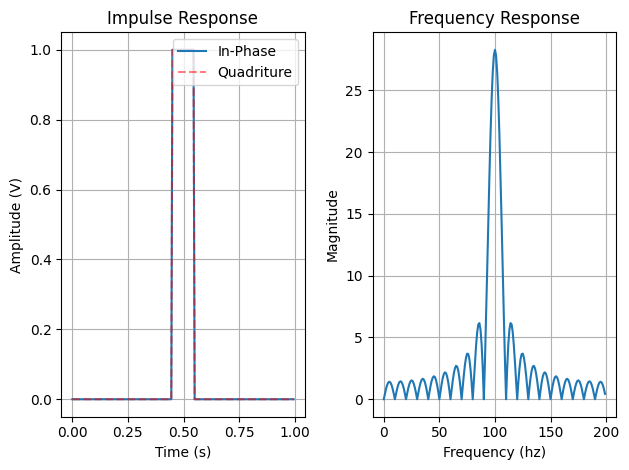

In [52]:
rect_width = T_sym/10
rect_pulse = pulse_rect(sps, T_sym, rect_width)
data = pulse_shape(data_symbols, rect_pulse, False)
create_plot(t, data)

## Sinc Pulse

In [44]:
def pulse_sinc(sps, t_sym, lobe_width):
    t = (t_sym/sps)*np.arange(-sps/2, sps/2)
    return np.sinc(2*t/lobe_width)

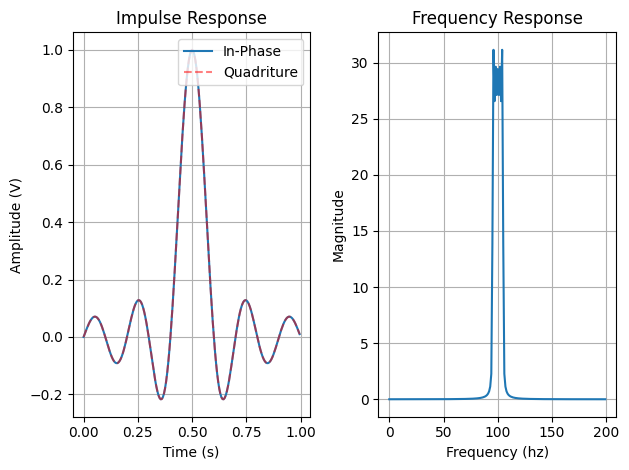

In [45]:
sinc_width = T_sym/5#5width od sinc main lobe
sinc_pulse = pulse_sinc(sps, T_sym, sinc_width)
data = pulse_shape(data_symbols, sinc_pulse, False)
f, data_f = my_fft(data.reshape(data.size), fs)
create_plot(t, data)

## Guassian Pulse Shaping

https://www.gaussianwaves.com/2014/07/generating-basic-signals-gaussian-pulse-and-power-spectral-density-using-fft/

Impulse Respose:

$$
g\left(t\right) = 
    \frac{1}{\sigma\sqrt{2\pi}}
    \left( e^{\frac{-t^2}{2\sigma^2}} \right)
$$

In [46]:
def pulse_guass(sps, t_sym, sigma):
    t = (t_sym/sps)*np.arange(-sps/2, sps/2)
    a = (1/sigma*np.sqrt(2*np.pi))
    b = -1*np.power(t, 2) / (2*sigma**2)
    return a*np.exp(b)

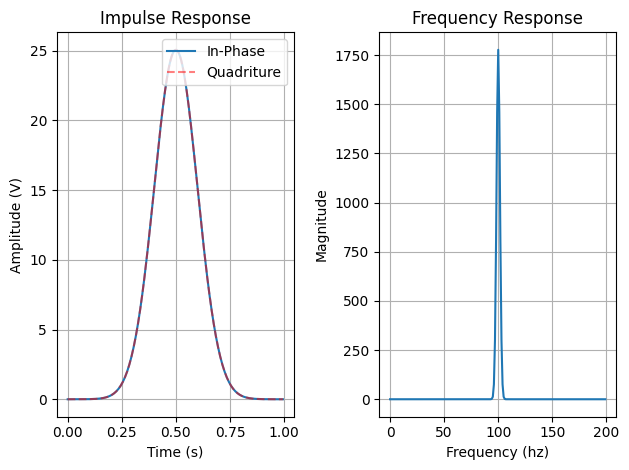

In [55]:
sigma = T_sym/10
guass_pulse = pulse_guass(sps, T_sym, sigma)
data = pulse_shape(data_symbols, guass_pulse, False)
create_plot(t, data)

## Raised Cosine Pulse Shaping

https://www.gaussianwaves.com/2018/10/raised-cosine-pulse-shaping/

The requency response of the Raisd Cosine pulse is defined as:

$$
P(f) = \begin{cases}
    T_{sym}    & , |f| \leq \frac{1-\alpha}{2T_{sym}} \leq 0 \\
    0.5T_{sym}\left[1 + \cos \left( \frac{\pi T_{sym}}{\alpha} \left[ |f| - \frac{1-\alpha}{2T_{sym}}\right]\right)
              \right] 
               & , \frac{1-\alpha}{2T_{sym}} \leq |f| \leq \frac{1+\alpha}{2T_{sym}} \\
    0          & , |f| \geq \frac{1+\alpha}{2T_{sym}}\\
\end{cases}
$$

which corresponds to the time-domain signal:

$$
p(t) = 
    \frac{
          \text{sinc}\left(\frac{\pi t}{T_{sym}}\right) 
          \cos\left(\frac{\alpha \pi t}{T_{sym}}\right)
         }
         {
          \left(1 - \left[\frac{2 \alpha t}{T_{sym}}\right]^2\right)
         }
$$

Where the $0 \leq \alpha \leq 1$. 

In [48]:
def pulse_rcos(sps, t_sym, alpha, span):
    #TODO: deal with div by zero cases....
    t = (span)*(t_sym/sps)*np.arange(-sps/2, sps/2)
    numerator = np.sinc((np.pi*t) / t_sym) * np.cos((alpha*np.pi*t) / t_sym)
    #denominator = ((np.pi*t)/t_sym) * (1 - np.power((2*alpha*t)/t_sym, 2))
    denominator = (1 - np.power((2*alpha*t)/t_sym, 2))
    print(np.argwhere(denominator==0))
    p = numerator/denominator
    p[np.argmax(p)] = 1
    return p

[[0]]


/tmp/ipykernel_4596/4121360020.py:8: RuntimeWarning: divide by zero encountered in divide
  p = numerator/denominator


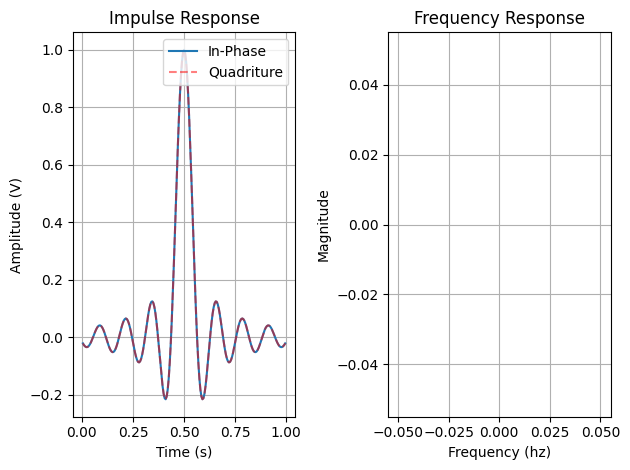

In [49]:
alpha = 0.2
span = 5
rcos_pulse = pulse_rcos(sps, T_sym, alpha, span)
data = pulse_shape(data_symbols, rcos_pulse, False)
create_plot(t, data)